## Unconfined, 2 layers, transient structured grid model with UZF, and infiltration (2021). 
DEM Top + 8 stress periods.

Note: dis, ic, K, wel, obs - 2 layers have been specified. IC as constant. Updated NPF.

In [1]:
import flopy
import os
import sys

import warnings
import pathlib as pl
import glob

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import geopandas as gpd
import rasterio as rio
import scipy.interpolate
import flopy.utils.binaryfile as bf

from flopy.utils import GridIntersect, Raster, binaryfile
from shapely.geometry import Polygon, Point
from rasterio.transform import from_origin
from matplotlib.ticker import MaxNLocator

from IPython.display import HTML
from matplotlib.collections import LineCollection

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [2]:
flopy.__version__

'3.8.0'

Load files of interpolated properties 

In [3]:
top_data_dem = np.loadtxt('../source_data_props/interpolated_properties-withDEM/DEM_top_elev_int.txt', delimiter=' ')
bot_data = np.loadtxt('../source_data_props/interpolated_properties-withDEM/bottom_elev_int.txt', delimiter=' ')
K_data = np.loadtxt('../source_data_props/interpolated_properties-withDEM/K_cond_int.txt', delimiter=' ')
#et_data = np.loadtxt('../source_data_props/interpolated_properties/evt_surf_elev_int.txt', delimiter=' ') #for uzf: evt is et but don't need if they are not important during experiment
#infil_data = np.loadtxt('../source_data_props/interpolated_properties/rch_int.txt', delimiter=' ') #foruzf: rch is infil but don't need if they are not important during experiment

In [4]:
np.max(top_data_dem)

4935.645231904197

In [5]:
heads_data = pd.read_csv('../source_data_props/interpolated_properties-withDEM/heads_int.csv')

Make simulation and model object with relevant packages

In [6]:
sim = flopy.mf6.MFSimulation(
    sim_name='rvt_ssma-4.4', exe_name="mf6", version="mf6", sim_ws="."
) 

ssma-2021-infiltration 

In [7]:
tdis = flopy.mf6.modflow.mftdis.ModflowTdis( 
    sim,
    pname="tdis",
    time_units="DAYS",
    nper=8,
    perioddata=[
        (1.0, 1,  1.2), #pre-infil
        (10.0, 20, 1.2), #infil basin
        (1.5, 3, 1.2), #infil standing water
        (5.0, 10, 1.2), #post-infil
        (0.5, 2, 1.2), #post-infil+rain
        (1.0, 2, 1.2), #post-infil
        (1.0, 2, 1.2), #post-infil+rain
        (20.0, 40, 1.2), #post-infil
    ]
)

In [8]:
ims = flopy.mf6.ModflowIms(
    sim, print_option='ALL', 
    pname='IMS', 
    complexity='MODERATE', 
    outer_dvclose=1e-1, #make it bigger
    outer_maximum=500,
    inner_maximum=100,
    inner_dvclose=1e-6, #make it smaller but one at a time
)

In [9]:
m = flopy.mf6.ModflowGwf(sim, modelname='rvt_ssma-4.4', model_nam_file='rvt_ssma-4.4.nam', save_flows=True, newtonoptions=['under_relaxation'])

In [10]:
nlay = 2
xlen = 300.0
ylen = 300.0
nrow = 200
ncol = 200 #in respect to delr delc
top_layer1 = top_data_dem
bot_layer1 = top_data_dem-7.65 #vadose zone thickness in ft
bot_layer2 = bot_data

In [11]:
top_layer1-bot_layer2

array([[20.09825078, 20.08018643, 20.06212208, ..., 18.72632621,
        18.73172321, 18.73712021],
       [20.10676133, 20.08869698, 20.08742487, ..., 18.73498166,
        18.74037866, 18.74577566],
       [20.11527188, 20.11399977, 20.12099847, ..., 18.74363711,
        18.74903411, 18.75443111],
       ...,
       [21.5818678 , 21.5850751 , 21.5882824 , ..., 23.03649779,
        22.97372204, 22.94188941],
       [21.5844739 , 21.5876812 , 21.5908885 , ..., 22.93986404,
        22.90803141, 22.93716591],
       [21.58708   , 21.5902873 , 21.5934946 , ..., 22.87417341,
        22.90330791, 22.93244241]])

In [12]:
dis = flopy.mf6.ModflowGwfdis(
    m,
    length_units='FEET',
    xorigin=593583.491,
    yorigin=846116.344,
    nlay=2,
    nrow=nrow,
    ncol=ncol,
    delr = np.full(ncol, xlen / ncol, dtype=float), #1.5ft
    delc = np.full(nrow, ylen / nrow, dtype=float), #1.5ft
    top=top_layer1,
    botm=[bot_layer1, bot_layer2],
    pname='DIS'
)

In [13]:
strt_ic = [4924.0, 4923.0]
ic = flopy.mf6.ModflowGwfic(m, pname="IC", strt=strt_ic)

In [14]:
mltp_hk_layer2 = 0.22

hk_layer2 = K_data*mltp_hk_layer2
hk_layer1 = hk_layer2*0.1

hk_layer2_k33 = hk_layer2 #isotropic
hk_layer1_k33 = hk_layer2*0.05

hk = [hk_layer1, hk_layer2] #layer1 silty clay, layer2 sand gravel 
k33 = [hk_layer1_k33, hk_layer2_k33]

npf = flopy.mf6.ModflowGwfnpf(m, icelltype=1, k=hk, k33=k33, pname = "NPF", save_flows=True)

In [15]:
np.max(hk_layer1_k33)

2.937674856380056

In [16]:
np.min(hk_layer2)

17.64482198930341

Since the upper layer of the model is UZF the model should only need constant head in saturated layer. 
No boundaries at the top infiltration will be directly added to the UZF which is the only dowmward from the top. This is lateral no flow.

In [17]:
chd_rec = {0: [], 1: [], 2: []}

for _, row in heads_data.iterrows():
    for i in range(3): #mentioning for three stress periods that would follow for the rest of the stress periods when not mentioned
        node = (1, int(row['row']), int(row['col']), row[f'h_t1s{i+1}']) #tuple
        if node not in chd_rec[i]: #removes duplicates
            chd_rec[i].append(node)

In [18]:
chd = flopy.mf6.ModflowGwfchd(
    model=m,
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)

In [19]:
sto = flopy.mf6.ModflowGwfsto(
        m, 
        pname = "STO", 
        iconvert = 3, 
        ss = 1e-07, 
        sy = 0.007,
        steady_state={0: True}, 
        transient={1: True},)  #the calibrated values

In [20]:
obsdict = {}
obslist = [["w1006", "head", (1, 99, 99)]]
obsdict["w1006-4.4.csv"] = obslist
wel_obs = flopy.mf6.ModflowUtlobs(m, print_input=False, continuous=obsdict)

### UZF

Rows and cols for the infiltration basin in the modelgrid collected from another notebook so that infiltration rate for UZF can be put only in the basin.

In [21]:
basin_rows_cols = np.array([(94, 91), (94, 92), (95, 89), (95, 90), (95, 91), (95, 92),
       (95, 93), (96, 88), (96, 89), (96, 90), (96, 91), (96, 92),
       (96, 93), (96, 94), (97, 88), (97, 89), (97, 90), (97, 91),
       (97, 92), (97, 93), (97, 94), (98, 88), (98, 89), (98, 90),
       (98, 91), (98, 92), (98, 93), (98, 94), (99, 88), (99, 89),
       (99, 90), (99, 91), (99, 92), (99, 93), (99, 94), (100, 89),
       (100, 90), (100, 91), (100, 92), (100, 93)], dtype=object)

Setting up for obs arguement in UZF

In [22]:
def add_uzf_obs(uz_obs_loc, obsnm, ifno, elev): #to add a single observation point to uz_obs_loc list
    uz_obs_loc.append((obsnm, "water-content", ifno, elev)) #four args and us_obs_loc is the list to which the observation point will be appended
    return uz_obs_loc #returns updated list

def add_uzf_wc_profile_obs(): #to create a list of observation points at various depths
    uz_obs_loc = []
    ifno = 12 #from package data text file

    depth1 = 0.58
    depth2 = 1.08
    depth3 = 1.75
    depth4 = 2.33
    depth5 = 2.83
    depth6 = 3.33
    depth7 = 3.83
    depth8 = 4.33

      # Observation names with row and col information
    obsnm1 = "uzf" + "_depth=" + str(depth1)
    obsnm2 = "uzf" + "_depth=" + str(depth2) 
    obsnm3 = "uzf" + "_depth=" + str(depth3) 
    obsnm4 = "uzf" + "_depth=" + str(depth4)  
    obsnm5 = "uzf" + "_depth=" + str(depth5) 
    obsnm6 = "uzf" + "_depth=" + str(depth6) 
    obsnm7 = "uzf" + "_depth=" + str(depth7)
    obsnm8 = "uzf" + "_depth=" + str(depth8)

        # Add observations for layer 1 at (96, 92)
    uz_obs_loc = add_uzf_obs(uz_obs_loc, obsnm1, ifno, depth1)
    uz_obs_loc = add_uzf_obs(uz_obs_loc, obsnm2, ifno, depth2)
    uz_obs_loc = add_uzf_obs(uz_obs_loc, obsnm3, ifno, depth3)
    uz_obs_loc = add_uzf_obs(uz_obs_loc, obsnm4, ifno, depth4)
    uz_obs_loc = add_uzf_obs(uz_obs_loc, obsnm5, ifno, depth5)
    uz_obs_loc = add_uzf_obs(uz_obs_loc, obsnm6, ifno, depth6)
    uz_obs_loc = add_uzf_obs(uz_obs_loc, obsnm7, ifno, depth7)
    uz_obs_loc = add_uzf_obs(uz_obs_loc, obsnm8, ifno, depth8)
    
    return uz_obs_loc

In [23]:
uz_obs_loc = add_uzf_wc_profile_obs()
uzf_obs = {"uzf_obs.uzfobs": uz_obs_loc}

In [24]:
uzf_obs

{'uzf_obs.uzfobs': [('uzf_depth=0.58', 'water-content', 12, 0.58),
  ('uzf_depth=1.08', 'water-content', 12, 1.08),
  ('uzf_depth=1.75', 'water-content', 12, 1.75),
  ('uzf_depth=2.33', 'water-content', 12, 2.33),
  ('uzf_depth=2.83', 'water-content', 12, 2.83),
  ('uzf_depth=3.33', 'water-content', 12, 3.33),
  ('uzf_depth=3.83', 'water-content', 12, 3.83),
  ('uzf_depth=4.33', 'water-content', 12, 4.33)]}

Setting up Package Data block for the UZF package. 
landflag=1 and ivertcon=0 meaning that the cell is at the surface and is not connected to an underlying uzf cell. 
surfdep represents the average topographic relief of surface undulations within a typical grid cell.
thti=x which means initial conditions are residual water content. theta-r<=theta-i<theta-s.
And finally a brooks-corey epsilon. EPSILON must be between 3.5 and 14.0.
Note: The same K value for the unsaturated zone in NPF package and vks in UZF is used. Usually, there is a difference between vks (vertical hydraulic conductivity) and horizontal hk, where the vks is less than the hks. It is better to have correspondence between the two. Also, NPF might get deactivated when UZF is used.
    If vks<infil rate, UZF will "reject" this infiltration. So, at an absolute minimum, VKS should either equal or exceed your infiltration rate to ensure that water gets into the simulation. 

In [25]:
vks_layer1 = hk_layer1_k33
package_data = []
total_uzfs = 0
iuzno = 0
ivc = 0
lndflg = 0
srfdep = 0
# Do a preliminary count
for row in range(m.modelgrid.nrow):
    for col in range(m.modelgrid.ncol):
        if m.modelgrid.idomain[0, row, col] == 0:
            continue
        total_uzfs += 1

        
for lay in range(m.modelgrid.nlay):
    for row in range(m.modelgrid.nrow):
        for col in range(m.modelgrid.ncol):
            if m.modelgrid.idomain[0, row, col] == 0:
                continue
            
            if lay == 0:
                ivc = iuzno + total_uzfs
                lndflg = 1
                srfdep = 0.01
            else:
                ivc = -1
                lndflg = 0
                srfdep = 0.00
            
            # iuzno, (layer, row, col), landflag, ivertcon, surfdep, vks, thtr, thts, thti, eps
            rec = (iuzno, (lay, row, col), lndflg, ivc, srfdep, vks_layer1[row, col], 0.02, 0.40, 0.05, 3.6)
            package_data.append(rec)
            iuzno += 1

In [26]:
np.min(vks_layer1)

0.8822410994651705

In [27]:
iuzno

80000

In [28]:
np.min(vks_layer1)

0.8822410994651705

Setting up Period Data block for the UZF package.
extdp=x which means that the evapotranspiration extinction depth is xft below the surface. 
extwc=y means that the extinction water content (low end of field capacity) is y (unitless). 
infiltration rate = 0.37 ft/day-need to specify finf=0 for the first stress period after my experiment ended.
Note: FINF=infiltration rate which gets applied to the entire stress period. Also, FINF needs to be set explicitly to zero for the first stress period after the infiltration ended, otherwise, UZF will use the previous stress period's value. The unsaturated zone will continue to drain to the water table in the atress periods after FINF is set equal to zero.
      The idomain value can't change over SPs, so, I will need to provide finf=0 for all the non-basin cells during the experimental infiltration. In summary, I will set active cells in all entire unsaturated zone, but set finf=0 to other cells except basin during the experimental infiltration. During the rain, I will set the finf=infiltration rate for the rain to the entire unsaturated zone.
      If the applied infiltration rate is larger than the vertical hydraulic conductivity, the actual infiltration will be reduced to the vertical hydraulic conductivity.

In [29]:
period_data = {}

nrow, ncol = m.modelgrid.nrow, m.modelgrid.ncol

for per in range(m.nper):
    spd = []
    iuzno = 0  

    for row in range(nrow):
        for col in range(ncol):
            if per in [0, 3, 5, 7]:
                finf_value = 0.0
            elif per in [4, 6]:
                finf_value = 0.10
            elif per == 1:
                if (row, col) in basin_rows_cols:
                    finf_value = 0.42
                else:
                    finf_value = 0.0
            elif per == 2:
                if (row, col) in basin_rows_cols:
                    finf_value = 0.37
                else:
                    finf_value = 0.0

            rec = (iuzno, finf_value, 0.001, 1.0, 0.2, 1.0, 1.0, 1.0)
            spd.append(rec)
            iuzno += 1

    period_data[per] = spd

In [30]:
iuzno

40000

Only specify SIMULATE_ET and UNSAT_ETAE if you have good reason to believe ET is removing water from the unsaturated zone profile. However, still need to specify values for HA, HROOT, ROOTACT, but they can be specified 0.0 in Period Block.  They still require specification even though they aren't actually being used by the code (if UNSAT_ETAE is not used).  If I do need to simulate ET, I would use the more simple formulation SIMULATE_ETWC.  I'm not sure that the _ETAE option was well tested.
Additional notes: infiltration and ET data are NOT required for our simulation. Need to include precipitation if we think it is important in the simulation and if there are important rain events contributing significant amounts of water to FINF. However, the precipitation climate data for RVT shows negligible infiltration during these periods.  Regarding temperature, if we have observations of temperature in the subsurface and we want to try to simulate infiltrating heat as a tracer for calibration purposes, then we can use it.  However, for that, we need the new GWE (groundwater energy tranport model).  Also, we do not need to enter temperature for ET calculations.  But, if we do want to simulate ET, the code requires to specify pET. Most models that calculate pET use temperature as an input, but as far as MODFLOW goes, we do not need to specify temperature.

In [31]:
uzf = flopy.mf6.ModflowGwfuzf(
        m,
        print_flows=True,
        save_flows=True,
        observations=uzf_obs,
        simulate_et=False, 
        unsat_etwc=False,
        ntrailwaves=15,
        nwavesets=500,
        nuzfcells=len(package_data),
        packagedata=package_data,
        perioddata=period_data,
        pname="UZF-1"
    )

In [32]:
m.modelgrid.idomain

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

## oc, write and run

In [33]:
headfile = "rvt_ssma-4.4.hds"
head_filerecord = [headfile]
budgetfile = "rvt_ssma-4.4.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "LAST"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    m,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [34]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model rvt_ssma-4.4...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 796 based on size of stress_period_data
    writing package sto...
    writing package obs_0...
    writing package uzf-1...
    writing package obs_1...
    writing package oc...


In [35]:
success, buff = sim.run_simulation(
    silent=None,
    pause=False,
    report=False,
    processors=None,
    normal_msg='normal termination',
    use_async=False,
    cargs=None,
    custom_print=None,
)

FloPy is using the following executable to run the model: mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:06:57 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held l

In [36]:
hobj = flopy.utils.HeadFile('rvt_ssma-4.4.hds', model=m)
hobj.headers

,kstp,kper,pertim,totim,text,ncol,nrow,ilay
52,1,1,1.0,1.0,HEAD,200,200,1
320104,1,1,1.0,1.0,HEAD,200,200,2
640156,20,2,10.0,11.0,HEAD,200,200,1
960208,20,2,10.0,11.0,HEAD,200,200,2
1280260,3,3,1.5,12.5,HEAD,200,200,1
1600312,3,3,1.5,12.5,HEAD,200,200,2
1920364,10,4,5.0,17.5,HEAD,200,200,1
2240416,10,4,5.0,17.5,HEAD,200,200,2
2560468,2,5,0.5,18.0,HEAD,200,200,1
2880520,2,5,0.5,18.0,HEAD,200,200,2


## Post-processing head data

Converting binary head values to ascii

In [37]:
head_values = hobj.get_data(mflay=1)
head_array = np.array(head_values)
head_array = head_array.reshape(-1, 1)
np.savetxt("rvt_ssma-4.4_hds.txt", head_array, delimiter=",", newline="\n")

In [38]:
well_locations = [
    Point(593730.641, 846267.604),
    Point(593729.391, 846264.894),
    Point(593728.141, 846262.314),
    Point(593728.871, 846256.484),
    Point(593730.851, 846260.844),
    Point(593732.221, 846263.654),
    Point(593733.491, 846266.344),
    Point(593735.321, 846270.994),
    Point(593739.921, 846268.894),
    Point(593737.941, 846264.394),
    Point(593736.731, 846261.664),
    Point(593735.251, 846258.954),
    Point(593733.221, 846254.464)
]

head_data = {
    "TS1_SP1": hobj.get_data(kstpkper=(0, 0)),
    "TS20_SP2": hobj.get_data(kstpkper=(19, 1)),
    "TS3_SP3": hobj.get_data(kstpkper=(2, 2)),
    "TS40_SP8": hobj.get_data(kstpkper=(39, 7))
}

In [39]:
def plot_head(head_name, head_data, well_locations, title_fontsize=14, tick_fontsize=14, cbar_fontsize=14, contour_fontsize=14):
    fig, ax = plt.subplots(figsize=(9, 10))
    ax.set_title(f"Head - {head_name}", fontsize=title_fontsize)

    # Create map view
    pmv = flopy.plot.PlotMapView(model=m, ax=ax)

    # Plot the head data with a color array
    img = pmv.plot_array(head_data, alpha=0.5, cmap='YlGnBu', edgecolor='none')

    # Colorbar settings
    cbar = plt.colorbar(img, ax=ax, label='Head (ft)')
    cbar.ax.tick_params(labelsize=cbar_fontsize)
    cbar.set_label('Head (ft)', fontsize=cbar_fontsize)

    # Contour settings
    levels = np.arange(4500, 5000, 0.1)
    contour = pmv.contour_array(head_data, levels=levels, colors='black', linewidths=0.5, linestyles='None')
    plt.clabel(contour, fontsize=contour_fontsize, fmt='%.2f')

    # Plot well locations
    well_x = [well.x for well in well_locations]
    well_y = [well.y for well in well_locations]
    ax.scatter(well_x, well_y, color='red', label='Wells', zorder=5, s=12)

    # Axis settings
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    plt.xticks(rotation=45)

    # Save the plot
    plt.tight_layout()
    plt.savefig(f'img/heads_mf6_{head_name}.png', dpi=300)
    plt.close()

# Loop through head data and plot
for head_name, head_array in head_data.items():
    plot_head(head_name, head_array, well_locations)

Plotting well head observation data 

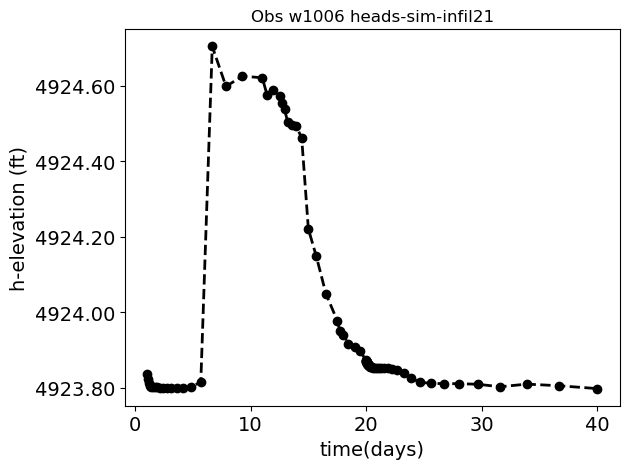

<Figure size 1000x600 with 0 Axes>

In [40]:
df1 = pd.read_csv('w1006-4.4.csv')
x1 = df1['time'][1:]
y1 = df1['W1006'][1:]

plt.plot(x1, y1, color='black', marker='o', linestyle='dashed', linewidth=2, markersize=6)

#plt.xlim(1, max(x))
#plt.ylim(min(y1), max(y1)+0.01)  
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)

plt.xlabel('time(days)', fontsize=14)
plt.ylabel('h-elevation (ft)', fontsize=14)
plt.title('Obs w1006 heads-sim-infil21')

plt.tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.savefig('./img/W1006_heads-unconf_2L_inf.png', dpi=300)
plt.figure(figsize=(10, 6))

plt.show()

## Post-processing UZF output

Plotting of water content vs depth at a single time step

In [41]:
uzdat_base = pd.read_csv(os.path.join(sim.sim_path, "uzf_obs.uzfobs"))

In [42]:
# Timing information for printing on animation
uzdat_base.set_index("time", inplace=True)

# Print the times array to debug
times = uzdat_base.index
print("Times Array:", times)

Times Array: Index([           1.0,  1.05356530693, 1.117843675247, 1.194977717227,
       1.287538567603, 1.398611588053, 1.531899212595, 1.691844362044,
       1.883778541383,  2.11409955659, 2.390484774839, 2.722147036737,
       3.120141751015, 3.597735408148, 4.170847796708,  4.85858266298,
       5.683864502506, 6.674202709938, 7.862608558856, 9.288695577558,
                 11.0, 11.41208791209, 11.90659340659,           12.5,
       12.69261378441, 12.92375032571, 13.20111417527, 13.53395079474,
        13.9333547381, 14.41263947013, 14.98778114857,  15.6779511627,
       16.50615517965,           17.5, 17.72727272727,           18.0,
       18.45454545455,           19.0, 19.45454545455,           20.0,
       20.00272336426, 20.00599140138, 20.00991304592, 20.01461901937,
       20.02026618751, 20.02704278927, 20.03517471139, 20.04493301793,
       20.05664298578,  20.0706949472, 20.08755730091, 20.10779212535,
       20.13207391468, 20.16121206188, 20.19617783853, 20.238136

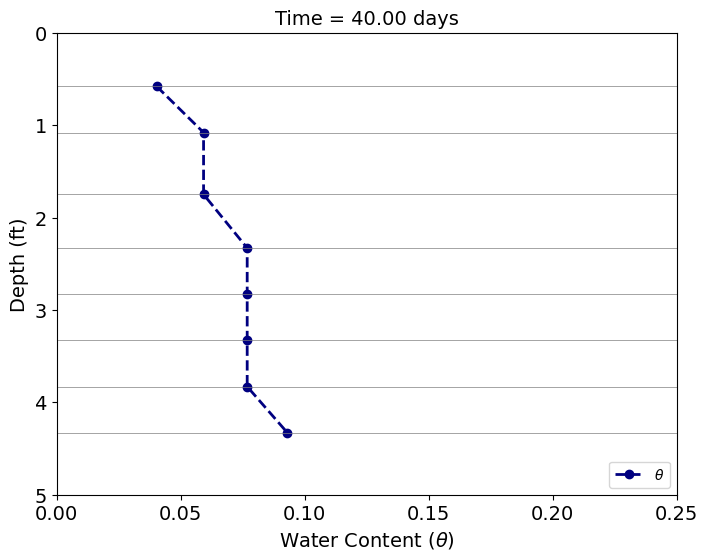

In [43]:
# Extract depths
depths_base = uzdat_base.columns
depths_base = [round(float(d.strip().split("=")[-1]), 2) for d in depths_base if "=" in d]

# Depth levels
layelvs = [0.58, 1.08, 1.75, 2.33, 2.83, 3.33, 3.83, 4.33]

# Animate results
matplotlib.rcParams["animation.embed_limit"] = 2**128

fig, ax1 = plt.subplots(figsize=(8, 6))  # Adjust width and height as needed

ax1.set_ylabel("Depth (ft)", fontsize=14)
ax1.set_xlabel("Water Content ($\\theta$)", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)

line, = ax1.plot([], [], marker='o', linestyle='dashed', linewidth=2, markersize=6, color='navy', label=r"$\theta$")
ax1.legend(loc="lower right")
ax1.set_xlim(0.0, 0.25)
ax1.set_ylim(0, 5)
ax1.invert_yaxis()  # Invert the y-axis

for yline in layelvs:
    ax1.axhline(yline, color="gray", linewidth=0.5)

times = uzdat_base.index

def init():
    ax1.set_title("Time = %.2f days" % (times[79]), fontsize = 14)

def update(j):
    # Moisture Content
    X = uzdat_base.iloc[j].values
    t = times[j]
    line.set_data(X, depths_base)
    ax1.set_title("Time = %.2f days" % (t), fontsize = 14)

    if j == 79:
        fig.savefig(os.path.join('img', f'frame_{j}.png'))
    
    return

ani = animation.FuncAnimation(fig, update, init_func=init, interval=100, frames=len(times))
HTML(ani.to_jshtml())